# Fake news detector

This project aims to create a fake news detector model that will predict wether a news article contains false information or not. The main goal is to build a realiable (85%+ accuracy rate) model.

## Environment

In [5]:
# Basic
import numpy as np
import pandas as pd
import re

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Visuals
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#Vectorizer storage
import pickle

# Misc
import time
import progressbar

In [6]:
news_df1 = pd.read_csv('data/Fake.csv')
news_df2 = pd.read_csv('data/True.csv')
news_df3 = pd.read_csv('data/train.csv')
#news_df4 = pd.read_csv('data/test.csv')

## Data Wrangling

In [7]:
news_df1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
news_df2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
news_df3.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
news_df1.loc[:,'label'] = 'Fake'
news_df2.loc[:,'label'] = 'Real'

In [11]:
news_df1.drop(columns = ["subject", 'date'], inplace = True)

In [12]:
news_df2.drop(["subject", 'date'], axis = 1, inplace = True)

In [13]:
news_df3.drop(["author", 'id'], axis = 1, inplace = True)
news_df3

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


In [14]:
news_df3['label'] = news_df3['label'].map({0: 'Real', 1: 'Fake'})
news_df3

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,Fake
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,Real
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",Fake
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,Fake
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,Fake
...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,Real
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,Real
20797,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,Real
20798,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",Fake


In [15]:
news_df3.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,Fake
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,Real
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",Fake
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,Fake
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,Fake


In [16]:
news = pd.concat([news_df1, news_df2, news_df3]).reset_index(drop = True)

In [17]:
news

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Fake
...,...,...,...
65693,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,Real
65694,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,Real
65695,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,Real
65696,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",Fake


In [18]:
news.to_csv('news dataframe')

In [19]:
news['label'].value_counts()

Fake    33894
Real    31804
Name: label, dtype: int64

In [20]:
# 
news = news.replace(' s ', 's ', regex=True)
news = news.replace(' t ', 't ', regex=True)
news = news.replace('2017', '2017 ', regex=True)

In [21]:
news.dropna(inplace=True)

In [22]:
news

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldnt wish all Americans a...,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Fake
...,...,...,...
65693,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,Real
65694,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,Real
65695,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,Real
65696,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",Fake


In [23]:
news['text'][0]

'Donald Trump just couldnt wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldnt do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017 Trumps tweet went down about as welll as you d expect.What kind of president sends a New Years greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency wont even a

In [24]:
def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    
    return keywords

# Test

In [30]:
test_news = news[64000:64100]

In [33]:
test_news

,title,text,label
64563,Trump llama a mantenimiento porque el botón nu...,Trump llama a mantenimiento porque el botón nu...,Fake
64564,"Wells Fargo Offers Regrets, but Doesn’t Admit ...",Wells Fargo was flowing with regrets on Friday...,Real
64566,No Proof Russia Hacked Hillary's E-mail,"Email \n""The Russian government has engaged in...",Fake
64567,"Leftist Philosopher Predicts ""Immediate Riots""...",French philosopher Michel Onfray claims if ...,Real
64568,Taser International Dominates the Police Body ...,When Micah Johnson went on a deadly shooting r...,Real
...,...,...,...
64662,Заседание Международного дискуссионного клуба ...,Заседание Международного дискуссионного клуба ...,Fake
64663,Se reencuentran dos gemeliers separados al nacer,Se reencuentran dos gemeliers separados al nac...,Fake
64664,Desperate Obama RIPS Comey: 'We Don't Operate ...,Desperate Obama RIPS Comey: 'We Don't Operate ...,Fake
64666,FranceInfo Changes Text on Its Website About “...,"October 29, 2016 Before: The tears of a 16-yea...",Fake


In [34]:
# Create an instance of RegexpTokenizer for alphanumeric tokens
tokeniser = RegexpTokenizer(r'\w+')
# Tokenise 'part1' string
tokens = tokeniser.tokenize(news['text'][0])
print(tokens)

['Donald', 'Trump', 'just', 'couldnt', 'wish', 'all', 'Americans', 'a', 'Happy', 'New', 'Year', 'and', 'leave', 'it', 'at', 'that', 'Instead', 'he', 'had', 'to', 'give', 'a', 'shout', 'out', 'to', 'his', 'enemies', 'haters', 'and', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'The', 'former', 'reality', 'show', 'star', 'had', 'just', 'one', 'job', 'to', 'do', 'and', 'he', 'couldnt', 'do', 'it', 'As', 'our', 'Country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'I', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'Fake', 'News', 'Media', 'a', 'Happy', 'and', 'Healthy', 'New', 'Year', 'President', 'Angry', 'Pants', 'tweeted', '2018', 'will', 'be', 'a', 'great', 'year', 'for', 'America', 'As', 'our', 'Country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'I', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 

In [149]:
vectoriser = TfidfVectorizer(analyzer=preprocess_text)

In [31]:
X_train = vectoriser.fit_transform(news['text'][:55000])

KeyboardInterrupt: 

In [34]:
X_train = vectoriser_1.transform(news['text'][:55000])

KeyboardInterrupt: 

In [28]:
LR = LogisticRegression()
LR.fit(X_train, news["label"][:55000].map({"Fake" : 1, "Real" : 0}))

NameError: name 'X_train' is not defined

In [197]:
# CAREFUL
# pickle.dump(LR, open("fake_detector", "wb"))
# pickle.dump(vectoriser, open("vectoriser", "wb"))

In [24]:
LR = LogisticRegression()

In [25]:
fake_detector = pickle.load(open("fake_detector", "rb"))
vectoriser_1 = pickle.load(open("vectoriser", "rb"))

In [35]:
fake_detector.score(vectoriser_1.transform(news['text'][55000:]), news["label"][55000:].map({"Fake" : 1, "Real" : 0}))

0.8802098802098802

In [26]:
breitbart = pd.read_csv('data/breitbart dataset')

In [27]:
washington_post = pd.read_csv('data/washington post dataset')

In [28]:
breitbart.head(3)

,Unnamed: 0,title,publication,author,date,year,month,url,content
0,0,Schumer: Trump’s Border Wall Won’t ’Get the Vo...,Breitbart,Pam Key,2017-03-26,2017.0,3.0,NaN,"Sunday ABC’s “This Week,” Senate Minority Lead..."
1,1,Levin: Trump’s Comments on Health Care Bill Fa...,Breitbart,Jeff Poor,2017-03-24,2017.0,3.0,NaN,Friday on his nationally syndicated radio show...
2,2,Dem Rep Grijalva: If Clinton Foundation Is ’Ex...,Breitbart,Ian Hanchett,2016-08-30,2016.0,8.0,NaN,"On Tuesday’s broadcast of “MSNBC Live,” Repres..."


In [29]:
washington_post.head(3)

,Unnamed: 0,title,publication,author,date,year,month,url,content
0,0,She came to Cleveland uncertain about Trump. S...,Washington Post,Robert Samuels,2016-07-22,2016.0,7.0,https://web.archive.org/web/20160723002212/htt...,CLEVELAND — From Aimee Winder Newton’s pe...
1,1,Mission creep doesn’t benefit patients at the ...,Washington Post,Samuel Harrington,2016-08-22,2016.0,8.0,https://web.archive.org/web/20160823000938/htt...,When my father was 88 and the picture of heal...
2,2,Putin’s ex-wife returns to the spotlight with ...,Washington Post,Adam Taylor,2017-04-06,2017.0,4.0,https://web.archive.org/web/20170406233922/htt...,Lyudmila Putin was the wife of Vladimir P...


In [30]:
#to_predict = vectoriser.transform([test_news["text"].loc[64563]])
breitbart_prediction = fake_detector.predict(vectoriser_1.transform(breitbart['content']))

In [31]:
washington_post_prediction = fake_detector.predict(vectoriser_1.transform(washington_post['content']))

In [32]:
breitbart_prediction

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [49]:
breitbart["fake"] = breitbart_prediction
breitbart

,Unnamed: 0,title,publication,author,date,year,month,url,content,fake
0,0,Schumer: Trump’s Border Wall Won’t ’Get the Vo...,Breitbart,Pam Key,2017 -03-26,2017.0,3.0,NaN,"Sunday ABC’s “This Week,” Senate Minority Lead...",0
1,1,Levin: Trump’s Comments on Health Care Bill Fa...,Breitbart,Jeff Poor,2017 -03-24,2017.0,3.0,NaN,Friday on his nationally syndicated radio show...,0
2,2,Dem Rep Grijalva: If Clinton Foundation Is ’Ex...,Breitbart,Ian Hanchett,2016-08-30,2016.0,8.0,NaN,"On Tuesday’s broadcast of “MSNBC Live,” Repres...",1
3,3,"Donald Trump: Candidates Called, Want to Join ...",Breitbart,Alex Swoyer,2016-01-28,2016.0,1.0,NaN,"GOP frontrunner Donald Trump, who is boycottin...",1
4,4,New York Times Sides with Leftist Mob at Everg...,Breitbart,Joel B. Pollak,2017 -06-18,2017.0,6.0,NaN,The New York Times offered a revisionist histo...,1
...,...,...,...,...,...,...,...,...,...,...
9995,9995,Benghazi Security Officer Warned U.S. Months B...,Breitbart,Aaron Klein,2016-06-28,2016.0,6.0,NaN,TEL AVIV — A U. S. government security offi...,0
9996,9996,Talent Agency WME-IMG Forming PAC for Trump Er...,Breitbart,Jerome Hudson,2017 -02-09,2017.0,2.0,NaN,Hollywood talent agency (William Morris En...,1
9997,9997,Diana West: Brent Bozell’s Brave New World — ’...,Breitbart,Breitbart News,2016-04-08,2016.0,4.0,NaN,Author Diana West reacts to Brent Bozell decla...,1
9998,9998,Gavin Newsom Calls Transgender Gun Activist ’D...,Breitbart,AWR Hawkins,2016-05-24,2016.0,5.0,NaN,Lt. Governor Gavin Newsom is facing a growing ...,1


In [76]:
breitbart_fake = breitbart.loc[breitbart['fake'] == 1]

In [77]:
breitbart_fake

,Unnamed: 0,title,publication,author,date,year,month,url,content,fake
2,2,Dem Rep Grijalva: If Clinton Foundation Is ’Ex...,Breitbart,Ian Hanchett,2016-08-30,2016.0,8.0,NaN,"On Tuesday’s broadcast of “MSNBC Live,” Repres...",1
3,3,"Donald Trump: Candidates Called, Want to Join ...",Breitbart,Alex Swoyer,2016-01-28,2016.0,1.0,NaN,"GOP frontrunner Donald Trump, who is boycottin...",1
4,4,New York Times Sides with Leftist Mob at Everg...,Breitbart,Joel B. Pollak,2017 -06-18,2017.0,6.0,NaN,The New York Times offered a revisionist histo...,1
5,5,Poll: Donald Trump Takes Lead in Florida - Bre...,Breitbart,Alex Swoyer,2016-08-24,2016.0,8.0,NaN,Donald Trump is holding a narrow lead over Hil...,1
6,6,ABC Cancels Conservative Tim Allen Sitcom ’Las...,Breitbart,Daniel Nussbaum,2017 -05-11,2017.0,5.0,NaN,ABC has cancelled its Tim sitcom Last Man St...,1
...,...,...,...,...,...,...,...,...,...,...
9993,9993,How BuzzFeed Editor Craig Silverman Helped Gen...,Breitbart,Jerome Hudson,2016-12-20,2016.0,12.0,NaN,Before Facebook unveiled measures to monitor t...,1
9996,9996,Talent Agency WME-IMG Forming PAC for Trump Er...,Breitbart,Jerome Hudson,2017 -02-09,2017.0,2.0,NaN,Hollywood talent agency (William Morris En...,1
9997,9997,Diana West: Brent Bozell’s Brave New World — ’...,Breitbart,Breitbart News,2016-04-08,2016.0,4.0,NaN,Author Diana West reacts to Brent Bozell decla...,1
9998,9998,Gavin Newsom Calls Transgender Gun Activist ’D...,Breitbart,AWR Hawkins,2016-05-24,2016.0,5.0,NaN,Lt. Governor Gavin Newsom is facing a growing ...,1


In [33]:
washington_post_prediction

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
washington_post["fake"] = washington_post_prediction
washington_post

,Unnamed: 0,title,publication,author,date,year,month,url,content,fake
0,0,She came to Cleveland uncertain about Trump. S...,Washington Post,Robert Samuels,2016-07-22,2016.0,7.0,https://web.archive.org/web/20160723002212/htt...,CLEVELAND — From Aimee Winder Newton’s pe...,1
1,1,Mission creep doesn’t benefit patients at the ...,Washington Post,Samuel Harrington,2016-08-22,2016.0,8.0,https://web.archive.org/web/20160823000938/htt...,When my father was 88 and the picture of heal...,1
2,2,Putin’s ex-wife returns to the spotlight with ...,Washington Post,Adam Taylor,2017 -04-06,2017.0,4.0,https://web.archive.org/web/2017 0406233922/ht...,Lyudmila Putin was the wife of Vladimir P...,0
3,3,"In Cleveland, sports prosperity is almost too ...",Washington Post,Adam Kilgore,2016-10-24,2016.0,10.0,https://web.archive.org/web/20161025001609/htt...,CLEVELAND — People here are trying to com...,0
4,4,"‘Affluenza’ teen flown back to U.S., turned ov...",Washington Post,Lindsey Bever,2016-01-28,2016.0,1.0,https://web.archive.org/web/20160128234833/htt...,“Affluenza” teen Ethan Couch was deport...,0
...,...,...,...,...,...,...,...,...,...,...
9995,9995,Baylor refuses to respond to reports of Presid...,Washington Post,Cindy Boren,2016-05-24,2016.0,5.0,https://web.archive.org/web/20160525000500/htt...,Baylor declined to respond to reports Tue...,0
9996,9996,The four cryptic words Donald Trump can’t stop...,Washington Post,Max Ehrenfreund,2016-06-13,2016.0,6.0,https://web.archive.org/web/20160614001316/htt...,A day after 49 people were killed in th...,1
9997,9997,Mystery of the spike in deaths between Christm...,Washington Post,Ariana Eunjung Cha,2016-12-22,2016.0,12.0,https://web.archive.org/web/2017 0101001641/ht...,As the Christmas season kicks into high g...,0
9998,9998,Good-golly Gorsuch may turn out to be a rascal...,Washington Post,Dana Milbank,2017 -03-21,2017.0,3.0,https://web.archive.org/web/2017 0322005015/ht...,The nomination of Neil Gorsuch presents the S...,0


In [81]:
washington_post_fake = washington_post.loc[washington_post['fake'] == 1]

In [82]:
washington_post_fake

,Unnamed: 0,title,publication,author,date,year,month,url,content,fake
0,0,She came to Cleveland uncertain about Trump. S...,Washington Post,Robert Samuels,2016-07-22,2016.0,7.0,https://web.archive.org/web/20160723002212/htt...,CLEVELAND — From Aimee Winder Newton’s pe...,1
1,1,Mission creep doesn’t benefit patients at the ...,Washington Post,Samuel Harrington,2016-08-22,2016.0,8.0,https://web.archive.org/web/20160823000938/htt...,When my father was 88 and the picture of heal...,1
8,8,Most young people don’t vote. Condescending to...,Washington Post,Jessica Contrera,2016-08-30,2016.0,8.0,https://web.archive.org/web/20160901001401/htt...,The video is filled with lewd innuend...,1
9,9,Obama: ‘All Americans should be deeply trouble...,Washington Post,David Nakamura,2016-07-07,2016.0,7.0,https://web.archive.org/web/20160708002327/htt...,President Obama added his voice Thursda...,1
13,13,Americans now think it’s okay to say what they...,Washington Post,Max Ehrenfreund,2016-06-17,2016.0,6.0,https://web.archive.org/web/20160618000037/htt...,One of the most infamous and influentia...,1
...,...,...,...,...,...,...,...,...,...,...
9988,9988,A pre-Civil War haven for free blacks is now h...,Washington Post,David Montgomery,2016-09-25,2016.0,9.0,https://web.archive.org/web/20160926002305/htt...,The sun is just dawning over a parkin...,1
9989,9989,People love watching nature on nest cams — unt...,Washington Post,Karin Brulliard,2016-05-19,2016.0,5.0,https://web.archive.org/web/20160520000708/htt...,The osprey cam at the Woods Hole Oceanogr...,1
9991,9991,Trump’s victory was history rhyming with itsel...,Washington Post,Joe Scarborough,2016-12-31,2016.0,12.0,https://web.archive.org/web/2017 0101001641/ht...,Americans view the election of a presiden...,1
9994,9994,These photos offer a rare glimpse inside Guant...,Washington Post,Bronwen Latimer,2016-05-04,2016.0,5.0,https://web.archive.org/web/20160505002228/htt...,In February 2016 President Obama called f...,1


In [34]:
breitbart_real = (breitbart_prediction == 0).sum()
breitbart_fake = (breitbart_prediction == 1).sum()

In [35]:
print(breitbart_real)
print(breitbart_fake)

5083
4917


In [36]:
washington_post_real = (washington_post_prediction == 0).sum()
washington_post_fake = (washington_post_prediction == 1).sum()

In [37]:
print(washington_post_real)
print(washington_post_fake)

5579
4421


In [38]:
from statsmodels.stats.proportion import proportions_ztest

In [39]:
proportions_ztest([breitbart_fake, washington_post_fake], [breitbart_real + breitbart_fake, washington_post_real + washington_post_fake])

(7.029920285268734, 2.0665156713200567e-12)

In [40]:
breitbart = breitbart.replace(' s ', 's ', regex=True)
breitbart = breitbart.replace(' t ', 't ', regex=True)
breitbart = breitbart.replace('2017', '2017 ', regex=True)

In [63]:
breitbart.content[0]

'Sunday ABC’s “This Week,” Senate Minority Leader Chuck Schumer ( ) said President Donald Trump’s proposal to build a wall on the U. S.  border wouldn’t get the votes on either the Democratic or Republican side.  Schumer said, “The border wall should be talked about, shouldn’t be rammed down people’s throats for a whole bunch of reasons. First, it’s not the best way to protect the border, everyone agrees on that. Second, it’s very expensive. Why don’t we use that money for roads? Third, let’s give the president a little chance to get Mexico to pay it. ” “Isn’t that what he told everybody that we weren’t going to pay it?” he continued. “Fourth, it’s got a big problem that Republicans in border states are opposing, Texas, Arizona, because there’s eminent domain, so you have to take private land. So instead of trying to jam it through on this   budget and saying take it or leave it, we should debate it in 2018’s budget over the summer. And, by the way, my prediction, it wouldn’t get the v

In [41]:
washington_post = washington_post.replace(' s ', 's ', regex=True)
washington_post = washington_post.replace(' t ', 't ', regex=True)
washington_post = washington_post.replace('2017', '2017 ', regex=True)

In [ ]:
def listToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele     
    return str1 

In [83]:
breitbart_content = breitbart_fake['title'].to_list()

In [84]:
breitbart_content = listToString(breitbart_content)

In [95]:
washington_post_content = washington_post_fake['title'].to_list()

In [96]:
washington_post_content = listToString(washington_post_content)

In [87]:
sw = stopwords.words("english")

In [109]:
new_sw = ['t', 's', 'the', 'on', 'it', 'that', 'to', 'a', 'get', 'or',
                                       'by', 'from', 'and', 'in', 'as', 'but', 'for', 'by', 'have been',
                                       'has been', 'which', 'while', 'u', 'with', 'at', 'wa', 'thi', 'was',
                                       'has', 'been', 'over', 'hi', 'pic twitter', 'of', 'its', 'them',
                                      'when', 'her', 'his', 'this', 'our', 'where', 'all', 'i', 'one', 'their', 
                                        'after', 'him', 'some', 'is', 'have', 'he', 'there', 'about', 'he said',
                                        'what', 'had', 'because', 'also', 'said', 'BreitbartTrump', 'Trump', 'Clinton']
for ele in new_sw:
    sw.append(ele)

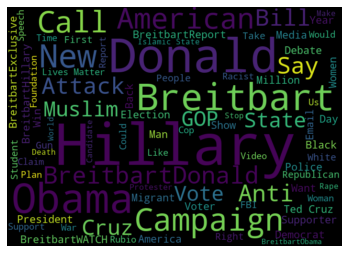

In [111]:
breitbart_text = breitbart_content

breitbart_wordcloud = WordCloud(width=700, height=500, stopwords = (sw), max_font_size=120, max_words=80).generate(breitbart_text)

plt.figure(figsize=(6, 9))
plt.imshow(breitbart_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

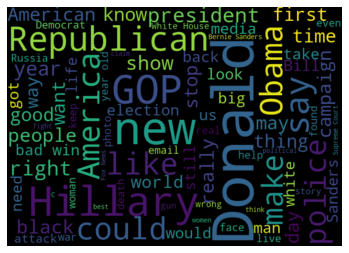

In [112]:
washington_post_text = washington_post_content

wp_wordcloud = WordCloud(width=700, height=500, stopwords = (sw), max_font_size=120, max_words=80).generate(washington_post_text)

plt.figure(figsize=(6, 9))
plt.imshow(wp_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
sw.remove('Trump')

In [109]:
LR.score(vectoriser.transform(sample["text"][:10]), sample["label"].map({"Fake" : 1, "Real" : 0})[:10])

0.7

In [70]:
test_news["label"].map({"Fake" : 1, "Real" : 0})

64563    1
64564    0
64566    1
64567    0
64568    0
        ..
64662    1
64663    1
64664    1
64666    1
64667    0
Name: label, Length: 100, dtype: int64

In [35]:
# Create an instance of TfidfVectorizer
vectoriser = TfidfVectorizer(analyzer=preprocess_text)
# Fit to the data and transform to feature matrix
X_train = vectoriser.fit_transform(test_news['text'])
# Convert sparse matrix to dataframe
X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
# Save mapping on which index refers to which words
col_map = {v:k for k, v in vectoriser.vocabulary_.items()}
# Rename each column using the mapping
for col in X_train.columns:
    X_train.rename(columns={col: col_map[col]}, inplace=True)
    
X_train.columns

KeyboardInterrupt: 

In [ ]:
X_train

In [ ]:
test_news['label']

In [ ]:
test_news['label'] = np.where(test_news['label']=='Fake', 1, 0)
test_news['label'].value_counts()

# Proportion hypothesis testing